## RAPIDS UMAP, TFIDF, and KMeans for Essay Topics Discovery

In this notebook we will cluster text data--- student essays--- using RAPIDS cudf, UMAP, TFIDF, and KMeans. First, we will convert each text into a TF-IDF embedding. Then we will use UMAP to reduce these embeddings to two dimensions. Lastly, we will use KMeans and HDBSCAN to cluster and segment the essay topics. 

**Credit**: The original author of the notebook is [Chris Deotte](https://www.kaggle.com/cdeotte). I am building upon his work by adding more detailed explanations, thoery, and code snippets for my own learning.

### Citations

* [UMAP-learn documentation](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)

* [Spark Documentation](https://spark.apache.org/docs/latest/mllib-feature-extraction.html#tf-idf)

* [Scikit-learn documentation](https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

* [McInnes, Leland, John Healy, and James Melville. "UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction." arXiv preprint arXiv:1802.03426 (2018)](https://arxiv.org/abs/1802.03426)

* [Nolet, Corey J., Victor Lafargue, Edward Raff, Thejaswi Nanditale, Tim Oates, John Zedlewski, and Joshua Patterson. "Bringing UMAP Closer to the Speed of Light with GPU Acceleration." arXiv preprint arXiv:2103.01121 (2021)](https://arxiv.org/abs/2008.00325)

## Data

The dataset contains argumentative essays written by U.S students in grades 6-12. The essays were annotated by expert raters for elements commonly found in argumentative writing.

The task is to predict the human annotations. We will first need to **segment** each essay into discrete rhetorical and argumentative elements (i.e., discourse elements) and then **classify** each element as one of the following:

* **Lead** - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis

* **Position** - an opinion or conclusion on the main question

* **Claim** - a claim that supports the position

* **Counterclaim** - a claim that refutes another claim or gives an opposing reason to the position

* **Rebuttal** - a claim that refutes a counterclaim

* **Evidence** - ideas or examples that support claims, counterclaims, or rebuttals.

* **Concluding Statement** - a concluding statement that restates the claims

The training set will consist of individual essays in a folder of `.txt` files, as well as a `.csv` file containing the annotated version of these essays. It is important to note that some parts of the essays will be unannotated (i.e., they do not fit into one of the classifications above).

### File Structure

* train.zip - folder of individual `.txt` files, with each file containing the full text of an essay response in the training set

* train.csv - a `.csv` file containing the annotated version of all essays in the training set

* id - ID code for essay response

* discourse_id - ID code for discourse element

* discourse_start - character position where discourse element begins in the essay response

* discourse_end - character position where discourse element ends in the essay response

* discourse_text - text of discourse element

* discourse_type - classification of discourse element

* discourse_type_num - enumerated class label of discourse element

* predictionstring - the word indices of the training sample, as required for predictions

* test.zip - folder of individual `.txt` files, with each file containing the full text of an essay response in the test set

## Imports

In [3]:
import os
import warnings
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count

import pandas as pd
import numpy as np

import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml import KMeans
from cuml import HDBSCAN
from cuml import UMAP
from cuml.metrics.trustworthiness import trustworthiness
from cuml.metrics.cluster.silhouette_score import cython_silhouette_score
from kneed import KneeLocator
from tqdm import tqdm

import matplotlib.pyplot as plt

print('Rapids cudf', cudf.__version__)
print('Rapids cuml', cuml.__version__)

Rapids cudf 21.10.01
Rapids cuml 21.10.02


## Global 

In [4]:
seed = 12
rs = np.random.RandomState(seed)
rs_cu = cupy.random.RandomState(seed)

fig_size = (15, 12)
plt.style.use('fivethirtyeight')

warnings.filterwarnings('ignore')

cpu_count()

2

## Data Ingestion

We will read train text files into a RAPIDS cudf.

In [5]:
def process_file(f: str) -> str:
    """
    Read in a txt file into python as a string.
    """
    with open('../input/feedback-prize-2021/train/' + f, 'r') as file:
        return file.read()

In [6]:
train_names, train_texts = [], []

# Use a pool of threads to read in the files asynchronously
with ThreadPoolExecutor() as executor:
    
    # List of file paths
    files = os.listdir('../input/feedback-prize-2021/train')
    # Submit each file to the executor, creating a list of Future objects--- one for each file
    futures = [executor.submit(process_file, f) for f in files]

    # We wish to keep the order in which the tasks are submitted to be consitent with 'files', so we do not use as_completed(futures)
    for f, future in zip(tqdm(files), futures):
        train_names.append(f.replace('.txt', '')) # Remove file extension
        train_texts.append(future.result()) # Get result of feature object, which returns the text string

100%|██████████| 15594/15594 [00:02<00:00, 6452.34it/s]


Load the data into GPU memory:

In [7]:
train_text_df = cudf.DataFrame({'id': train_names, 'text': train_texts})
train_text_df.head()

,id,text
0,62C57C524CD2,I think we should be able to play in a sport i...
1,80667AD3FFD8,Some schools require summer projects for stude...
2,21868C40B94F,Driverless cars have been argued and talked ab...
3,87A6EF3113C6,"The author of ""The Challenge of Exploring Venu..."
4,24687D08CFDA,"Wow, from the mar really look like humans face..."


In [8]:
print(f'There are {train_text_df.id.unique().shape[0]} unique essays in the training set')

There are 15594 unique essays in the training set


## TF-IDF

Vectorization is the general process of turning a collection of text documents into numerical feature vectors. A central question in text mining and natural language processing is how to quantify what a document is about. The **term frequency-inverse document frequency** (TF-IDF) is a feature vectorization method that reflects *the importance of a term to a document in the corpus*. 

Denote a term by $t$, a document by $d$, and the corpus by $D$ (a collection of documents). 

1. Term frequency $T F(t, d)$ is the number of times that term $t$ appears in document $d$ 

2. Document frequency $D F(t, D)$ is the number of documents that contains term $t$. 

If we only use **term frequency** to measure the importance, it is very easy to over-emphasize terms that appear very often but carry little information about the document, e.g., "a", "the", and "of". If a term appears very often across the corpus, it means it doesn't carry special information about a particular document. On the other hand, the **inverse document frequency** is a numerical measure of how much information a term provides:

$$
I D F(t, D)=\log \frac{|D|+1}{D F(t, D)+1}
$$
where 

* $|D|$ is the total number of documents in the corpus
* $D F(t, D)$ is the number of documents that contains term $t$

Since the logarithm is used, if a term $t$ appears in all documents, its IDF value $I D F(t, D)$ becomes 0. To see this, note that a term $t$ appearing in all documents means that $D F(t, D)=|D|$, making the the ratio $\frac{|D|+1}{D F(t, D)+1}=1$ and $\log(1)=0$. Note that a smoothing term of $1$ is applied to avoid dividing by zero for terms outside the corpus. The **TF-IDF** measure is simply the product of TF and IDF:

$$
\operatorname{TFIDF}(t, d, D)=T F(t, d) \cdot \operatorname{IDF}(t, D)
$$

### Spark ML

The implementation in [Spark](https://spark.apache.org/docs/latest/mllib-feature-extraction.html#tf-idf) seperates TF and IDF into `HashingTF` and `IDF`. The term frequency implementation utilizes the hashing trick. A raw feature is mapped into an index (term) by applying a hash function. Then, the term frequencies are calculated based on the mapped indices. This approach avoids the need to compute a global term-to-index map, which can be expensive for a large corpus; however, it suffers from potential hash collisions, where different raw features may become the same term after hashing. To reduce the chance of collision, we can increase the target feature dimension, i.e., the number of buckets of the hash table. The default feature dimension is $2^{20}=1,048,576$.

### Scikit-learn & Cuml

The `TfidfVectorizer` is equivalent to first applying `CountVectorizer` followed by `TfidfTransformer`. 

* `CountVectorizer` implements two steps
    * **tokenizing** strings and giving an integer id for each possible token (a meaningful unit of text, such as a word), for instance by using white-spaces and punctuation as token separators
    * **counting** the occurrences of tokens in each document (in our case, an essay)
    
* `TfidfTransformer` transforms a count matrix to a normalized (unit norm L2 or L1) tf or tf-idf representation

We will use TF-IDF to convert each text (essay) into an embedding vector of length 25,000. We also set the `binary` argument to `True`, where all non zero counts are set to 1. This is useful for discrete probabilistic models that model binary events rather than integer counts.

In [9]:
tfidf = TfidfVectorizer(
    stop_words='english', 
    analyzer='word', # Feature should be made of word n-grams
    max_features=25_000, # Build a vocabulary that only considers the top 25,000 features ordered by term frequency across corpus
    binary=True,
    norm='l2', # Sum of squares of vector elements is 1 and cosine similarity between two vectors is their dot product when l2 norm has been applied
    smooth_idf=True
)
text_embeddings = tfidf.fit_transform(train_text_df.text).toarray() # Convert to cupy.ndarray

type(text_embeddings)

cupy._core.core.ndarray

The output is a TF-IDF-weighted document-term matrix where

* each row represents one document (an essay)

* each column represents one term

* each value contains the **TF-IDF** measure $\operatorname{TFIDF}(t, d, D)$ for term $t$, document $d$, and corpus $D$

The dimensions of the matrix is $15,594 \times 25,000$ since we only consider the top 25,000 features ordered by term frequency across the corpus (a collection of documents).


In [10]:
text_embeddings.shape

(15594, 25000)

To get a sense of the sparsity of the TF-IDF matrix:

In [11]:
print('The percentage of zero elements is', (1 - (cupy.count_nonzero(text_embeddings) / text_embeddings.size)).item())

The percentage of zero elements is 0.9958502834423496


## Uniform Manifold Approximation and Projection

> Dimension reduction algorithms tend to fall into two categories; those that seek to preserve the pairwise distance structure amongst all the data samples and those that favor the preservation of local distances over global distance. Algorithms such as PCA, MDS, and Sammon mapping fall into the former category while t-SNE, Isomap, LargeVis, Laplacian eigenmaps and diffusion maps all fall into the latter category. 

UMAP is also an algorithm that falls into the second category--- local distances over global distance. However, the original paper also states that UMAP 'arguably preserves more of the global structure' than a state-of-the-art algorithm such as TSNE.

1. In the first stage, a k-nearest neighbors $(k-\mathrm{NN})$ graph for the data points is constructed using a distance metric, $d(x, y)$. 

2. The second stage weights the closest neighbors around each vertex (node or a data point) in the nearest neighbors graph, converting them to fuzzy sets and combining them into a fuzzy union. The fuzzy set membership function learns a locally adaptive exponential kernel that smoothes the distances in each local neighborhood (a group of data points) of the k-NN graph.

3. In the third stage, the embeddings are laid out in the topological space using stochastic gradient descent. Explicitly, if the set of all possible 1-simplices is $E$, and we have weight functions such that $w_h(e)$ is the weight of the 1-simplex $e$ in the high dimensional case and $w_l(e)$ is the weight of $e$ in the low dimensional case, then the cross entropy will be

    $$
    \sum_{e \in E} w_h(e) \log \left(\frac{w_h(e)}{w_l(e)}\right)+\left(1-w_h(e)\right) \log \left(\frac{1-w_h(e)}{1-w_l(e)}\right)
    $$

    In terms of a graph, we can view minimizing the cross entropy as a kind of force directed graph layout algorithm. The first term, $w_h(e) \log \left(\frac{w_h(e)}{w_l(e)}\right)$ provides an attractive force between the points $e$ spans whenever there is a large weight associated to the high dimensional case. This is because this term will be minimized when $w_l(e)$ is as large as possible, which will occur when the distance between the points is as small as possible.

    In contrast, the second term $\left(1-w_h(e)\right) \log \left(\frac{1-w_h(e)}{1-w_l(e)}\right)$ provides a repulsive force between the ends of $e$ whenever $w_h(e)$ is small. This is because the term will be minimized by making $w_l(e)$ as small as possible.
    
    On balance this process of pull and push, mediated by the weights on edges of the topological representation of the high dimensional data, will let the low dimensional representation settle into a state that relatively accurately represents the overall topology of the source data.
    
    **Both TSNE and UMAP are transductive methods as far as their implementations in softwares, which means they cannot be applied to new, unseen data without re-learning the embeddings.**

### Weaknesses

According to the paper:

* Interpretability

> The dimensions of the UMAP embedding space have no specific meaning, unlike PCA where the dimensions are the directions of greatest variance in the source data. Furthermore, since UMAP is based on the distance between observations rather than the source features, it does not have an equivalent of factor loadings that linear techniques such as PCA, or Factor Analysis can provide. If strong interpretability is critical we therefore recommend linear techniques such as PCA, NMF or pLSA.

* Global structure preservation

> UMAP therefore concerns itself primarily with accurately representing local structure. While we believe that UMAP can capture more global structure than these other techniques, it remains true that if global structure is of primary interest then UMAP may not be the best choice for dimension reduction. Multi-dimensional scaling specifically seeks to preserve the full distance matrix of the data, and as such is a good candidate when all scales of structure are of equal importance.

### Hyper-parameters

According to the paper, the UMAP algorithm takes four hyper-parameters:

1. $n$ is the number of neighbors to consider when approximating the local metric
    - The value $n$ represents some degree of trade-off between fine grained and large scale manifold features — **smaller** values will ensure detailed manifold structure is accurately captured (at a loss of the “big picture” view of the manifold), while **larger** values will capture large scale manifold structures, but at a loss of fine detail structure which will get averaged out in the local approximations.
2. $d$ is the target embedding dimension
3. `min-dist` is the desired separation between close points in the embedding space
    - Increasing the value of `min-dist` will force the embedding to spread points out more, assisting visualization (and avoiding potential overplotting issues). We view `min-dist` as an essentially aesthetic parameter, governing the appearance of the embedding, and thus is more important when using UMAP for visualization.
4. `n-epochs` is the number of training epochs to use when optimizing the low dimensional representation

### Variations of UMAP Hyperparameters `n` and `min-dist` Result in Different Embeddings

<center>
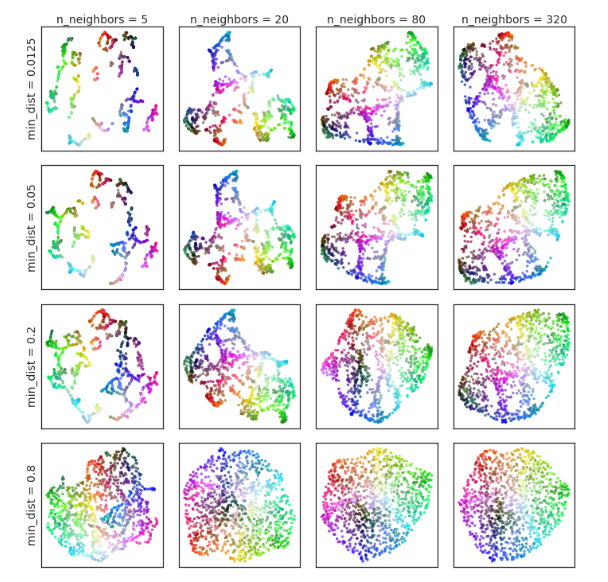
</center>

We will use UMAP to reduce the $25,000$-dimensional embedding vectors to two dimensions. Specifically, we will try different configurations and visually assess the quality of our visualization. The hyper-parameters we will tune are:

* `n_neighbors`: The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation. Larger values result in more global views of the manifold, while smaller values result in more local data being preserved. In general values should be in the range 2 to 100.

* `metric`: Distance metric to use. Because we are doing text mining, we will choose between 'euclidean', 'cosine' and 'jaccard' similarities

* `n_epochs`: The number of training epochs to be used in optimizing the low dimensional embedding. Larger values result in more accurate embeddings. If None is specified a value will be selected based on the size of the input dataset (200 for large datasets, 500 for small).

* `min_dist`: The effective minimum distance between embedded points. Smaller values will result in a more clustered/clumped embedding where nearby points on the manifold are drawn closer together, while larger values will result on a more even dispersal of points. The value should be set relative to the spread value, which determines the scale at which embedded points will be spread out.

* `spread`: The effective scale of embedded points. In combination with `min_dist`, this determines how clustered/clumped the embedded points are.

In [12]:
umap = UMAP(
    n_neighbors=15,
    n_components=2,
    # metric='jaccard', # Key word error in cuml 21.10.02
    n_epochs=200,
    min_dist=0.1, # Try values in the range (0.1 - 0.8)
    spread=1
)

embed_2d = umap.fit_transform(text_embeddings)
embed_2d = cupy.asnumpy(embed_2d) # Convert to numpy array

embed_2d.shape

(15594, 2)

Visualization of two-dimensional embeddings:

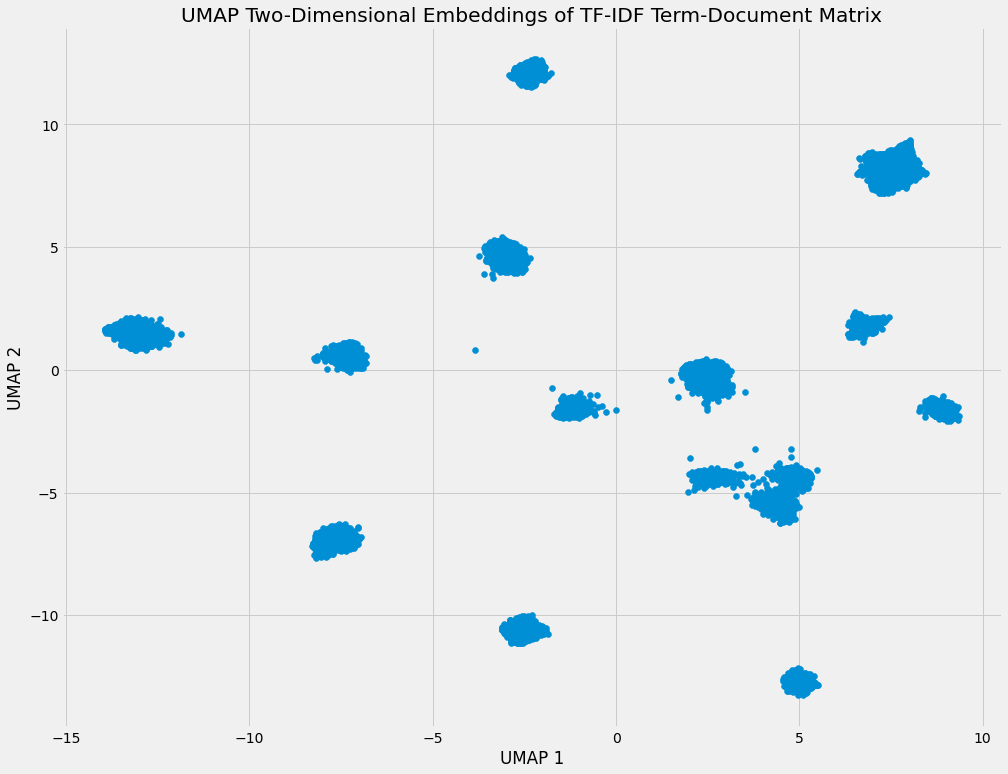

In [13]:
x = embed_2d[:, 0]
y = embed_2d[:, 1]

fig, ax = plt.subplots(figsize=fig_size)
ax.scatter(x, y)
plt.title('UMAP Two-Dimensional Embeddings of TF-IDF Term-Document Matrix')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show();

Another evaluation assessment of the quality of the embedding is the `trustworthiness` score, which is defined in the range $[0, 1]$. This score expresses the extent to which the local structure is retained in the embeddings. 

$$
T(k)=1-\frac{2}{n k(2 n-3 k-1)} \sum_{i=1}^n \sum_{j \in \mathcal{N}_i^k} \max (0,(r(i, j)-k))
$$

where 

* $k$ is a hyperparameter that determines the number of nearest neighbors to consider when evaluating the local structure of the data.

* $n$ is the total number of data points.

* $\mathcal{N}_i^k$ is the set of $k$ nearest neighbors of data point $i$ in the embedding space. In other words, these are the $k$ data points in the embedding space that are closest to point $i$.

* $r(i,j)$ is the rank of data point $j$ among the nearest neighbors of $i$ in the original data space. In other words, if we order the nearest neighbors of data point $i$ in the original data space in terms of their distances to data point $i$, then data point $j$ is the $r(i,j)$-th closest point to data point $i$ in the original space.

* The double sum in the formula goes over all data points $i$ and their $k$ nearest neighbors in the embedding space. For each pair of data points $(i,j)$, it calculates the **difference between the rank of $j$ among the nearest neighbors of $i$ in the original data space and its rank among the $k$ nearest neighbors of $i$ in the embedding space**. 

  Any unexpected nearest neighbors in the embedding space are penalised in proportion to their rank in the input space--- **farther points in the original space should not result in closer points in the embedding space**. 
  
  The overall score is then computed as $1$ minus the average of these differences, normalized by a factor that depends on $n$ and $k$.

**The higher the score, the more trustworthy the embeddings**.

In [14]:
trust_score = trustworthiness(
    X=text_embeddings,
    X_embedded=embed_2d,
    n_neighbors=15,
    metric='euclidean',
    batch_size=512
)

trust_score

0.9572989471913338

## K-Means Clustering

We will now use KMeans to find clusters of these lower dimensional embeddings of the TF-IDF term-document matrix. The clusters can then be interpreted as representing essay topics in the downstream analysis.

In [15]:
cupy_embed_2d = cupy.asarray(embed_2d)
k_range = range(5, 21)
sc_list = []

for k in tqdm(k_range):
    kmeans_model = cuml.KMeans(
        n_clusters=k,
        init='scalable-k-means++',
        n_init=10
    )
    kmeans_model.fit(cupy_embed_2d)
    # Compute score
    sc_list.append(cython_silhouette_score(X=cupy_embed_2d, labels=kmeans_model.labels_, metric='euclidean'))

100%|██████████| 16/16 [00:02<00:00,  6.82it/s]


Visualize the Silhouette score as a function with respect to number of clusters:

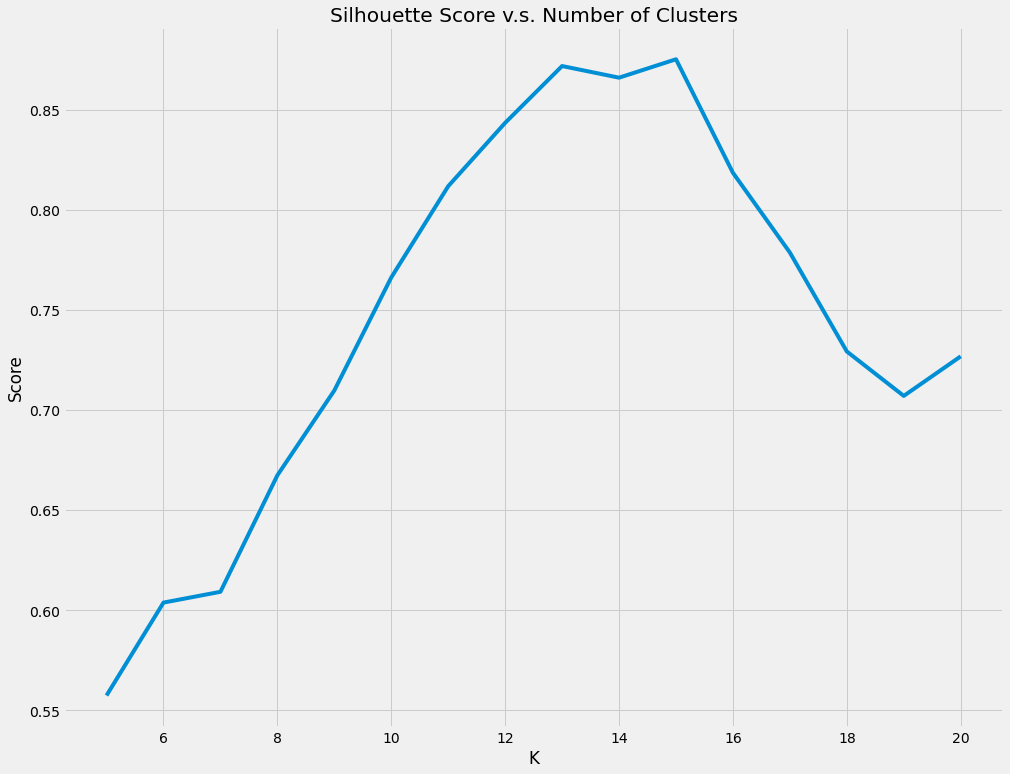

In [16]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(k_range, sc_list)
plt.title('Silhouette Score v.s. Number of Clusters')
plt.xlabel('K')
plt.ylabel('Score')
plt.show();

Higher scores relate to models with better defined clusters. Using the Kneedle algorithm:

In [17]:
kneedle = KneeLocator(x=k_range, y=sc_list, curve='concave', direction='increasing', interp_method='polynomial')

print('The hueristically determined optimal number of clusters is', kneedle.knee)

The hueristically determined optimal number of clusters is 13


Now, we fit the final KMeans model:

In [18]:
k_means_model = cuml.KMeans(
        n_clusters=kneedle.knee,
        init='scalable-k-means++',
        n_init=10
    )
k_means_model.fit(cupy_embed_2d)

# Add cluster labels to dataframe
train_text_df['k_means_clusters'] = k_means_model.labels_

train_text_df.head(5)

,id,text,k_means_clusters
0,62C57C524CD2,I think we should be able to play in a sport i...,7
1,80667AD3FFD8,Some schools require summer projects for stude...,2
2,21868C40B94F,Driverless cars have been argued and talked ab...,3
3,87A6EF3113C6,"The author of ""The Challenge of Exploring Venu...",10
4,24687D08CFDA,"Wow, from the mar really look like humans face...",4


Visualize the output of the clustering model:

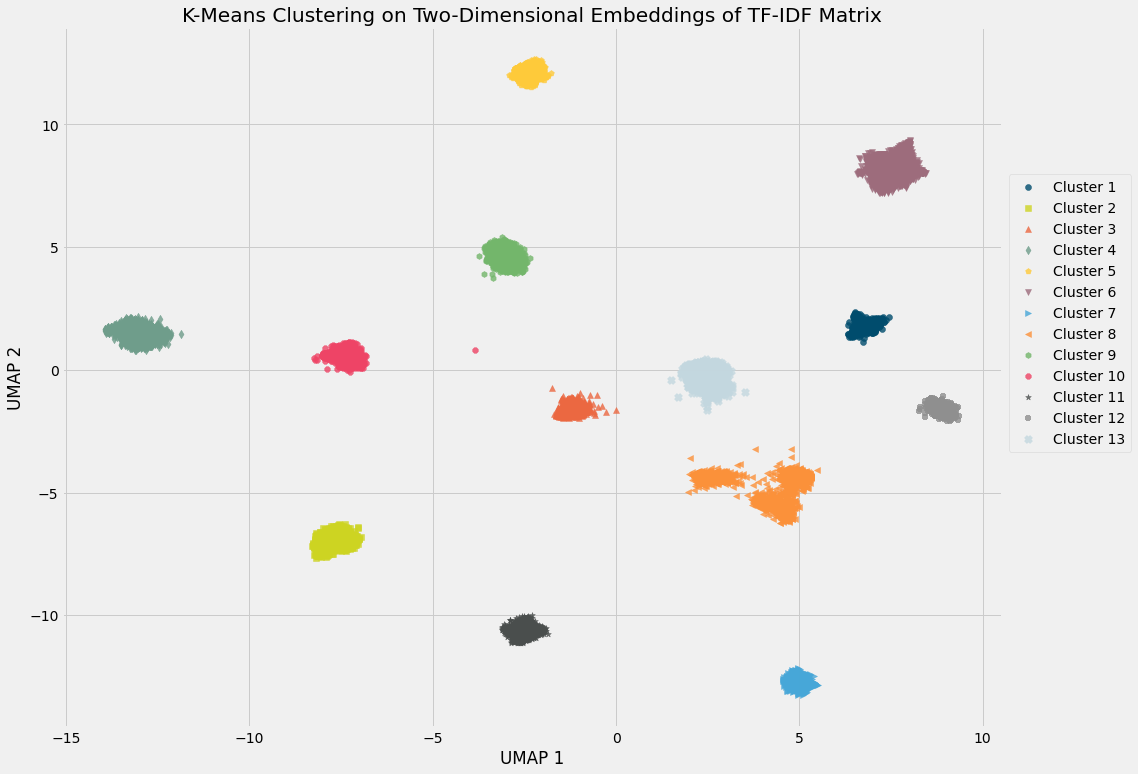

In [19]:
c_kmeans = cupy.asnumpy(k_means_model.labels_)

# Define a color map and markers for each cluster
colors = ['#004c6d', '#cdd422', '#eb6841', '#6f9d8b', '#ffca3a', '#9d6c7c', '#47a7d8', '#fc913a', '#73b66b', '#ee4466', '#4a4e4d', '#8f8f8f', '#c3d7df']
markers = ['o', 's', '^', 'd', 'p', 'v', '>', '<', 'h', '8', '*', '+', 'x']
alpha = [0.8] * len(colors)

# Create the scatter plot
fig, ax = plt.subplots(figsize=fig_size)
for index, c in np.ndenumerate(np.unique(c_kmeans)):
    mask = c_kmeans == c
    ax.scatter(x[mask], y[mask], c=colors[index[0]], marker=markers[index[0]], alpha=alpha[index[0]])
    
# Add axis labels and show the plot
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('K-Means Clustering on Two-Dimensional Embeddings of TF-IDF Matrix')
plt.legend(['Cluster ' + str(i) for i in range(1, len(colors) + 1)], bbox_to_anchor=(1, 0.8))
plt.show();

## HDBSCAN

The visualization above shows that, visually speaking, a partitional clustering algorithm like KMeans works well on our trainin data. However, we will also explore a density-based clustering algorithm as a comparison. HDBSCAN has two important hyper-parameters to tune:

* `min_cluster_size`

In [20]:
min_cluster_size_range = range(5, 60, 5)
sc_list_min_cluster_size = []

for min_cluster_size in tqdm(min_cluster_size_range):
    hdbscan_model = HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=5,
        metric='euclidean'
    )
    hdbscan_model.fit(cupy_embed_2d)
    # Add score
    sc_list_min_cluster_size.append(cython_silhouette_score(X=cupy_embed_2d, labels=hdbscan_model.labels_))

  9%|▉         | 1/11 [00:00<00:05,  1.90it/s]

Label prop iterations: 17
Label prop iterations: 10
Label prop iterations: 10
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 6
4938,171,330,23,286,1403
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3463,71,125,11,118,948
Label prop iterations: 2
Iterations: 1
3479,48,88,7,59,822


 18%|█▊        | 2/11 [00:01<00:04,  1.97it/s]

Label prop iterations: 17
Label prop iterations: 10
Label prop iterations: 10
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 6
3392,161,308,23,294,2254
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3233,67,115,10,111,863
Label prop iterations: 2
Iterations: 1
3210,47,77,7,54,747
Label prop iterations: 17


 27%|██▋       | 3/11 [00:01<00:03,  2.01it/s]

Label prop iterations: 10
Label prop iterations: 10
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 6
3366,178,628,25,289,1934
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3235,67,114,11,100,885
Label prop iterations: 2
Iterations: 1
3247,55,77,7,54,737
Label prop iterations: 17


 36%|███▋      | 4/11 [00:01<00:03,  2.03it/s]

Label prop iterations: 10
Label prop iterations: 10
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 6
3589,163,312,25,284,1614
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3202,72,119,11,101,863
Label prop iterations: 2
Iterations: 1
3163,59,76,7,56,747
Label prop iterations: 17


 45%|████▌     | 5/11 [00:02<00:02,  2.03it/s]

Label prop iterations: 10
Label prop iterations: 10
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 6
3341,163,309,23,351,1987
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3218,76,114,9,103,873
Label prop iterations: 2
Iterations: 1
3218,47,78,6,55,740


 55%|█████▍    | 6/11 [00:02<00:02,  2.05it/s]

Label prop iterations: 17
Label prop iterations: 10
Label prop iterations: 10
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 6
3449,164,301,23,289,1928
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3263,72,116,12,107,878
Label prop iterations: 2
Iterations: 1
3353,59,79,8,59,748


 64%|██████▎   | 7/11 [00:03<00:01,  2.06it/s]

Label prop iterations: 17
Label prop iterations: 10
Label prop iterations: 10
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 6
3380,165,310,45,280,2214
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3253,68,113,10,124,852
Label prop iterations: 2
Iterations: 1
3231,48,78,6,54,746


 73%|███████▎  | 8/11 [00:03<00:01,  2.06it/s]

Label prop iterations: 17
Label prop iterations: 10
Label prop iterations: 10
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 6
3352,179,315,24,293,1944
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3211,66,116,9,103,886
Label prop iterations: 2
Iterations: 1
3187,47,76,6,54,754


 82%|████████▏ | 9/11 [00:04<00:00,  2.07it/s]

Label prop iterations: 17
Label prop iterations: 10
Label prop iterations: 10
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 6
3628,160,316,24,277,1937
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3182,68,119,11,99,871
Label prop iterations: 2
Iterations: 1
3211,47,78,7,52,755


 91%|█████████ | 10/11 [00:04<00:00,  2.07it/s]

Label prop iterations: 17
Label prop iterations: 10
Label prop iterations: 10
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 6
3574,160,314,27,295,2290
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3209,69,115,10,100,879
Label prop iterations: 2
Iterations: 1
3215,46,77,8,52,753


100%|██████████| 11/11 [00:05<00:00,  2.05it/s]

Label prop iterations: 17
Label prop iterations: 10
Label prop iterations: 10
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 6
4548,168,298,22,284,1359
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3170,68,114,10,101,882
Label prop iterations: 2
Iterations: 1
3261,46,77,6,53,742


Visualize the performance of the clustering model on various values for `min_cluster_size`:

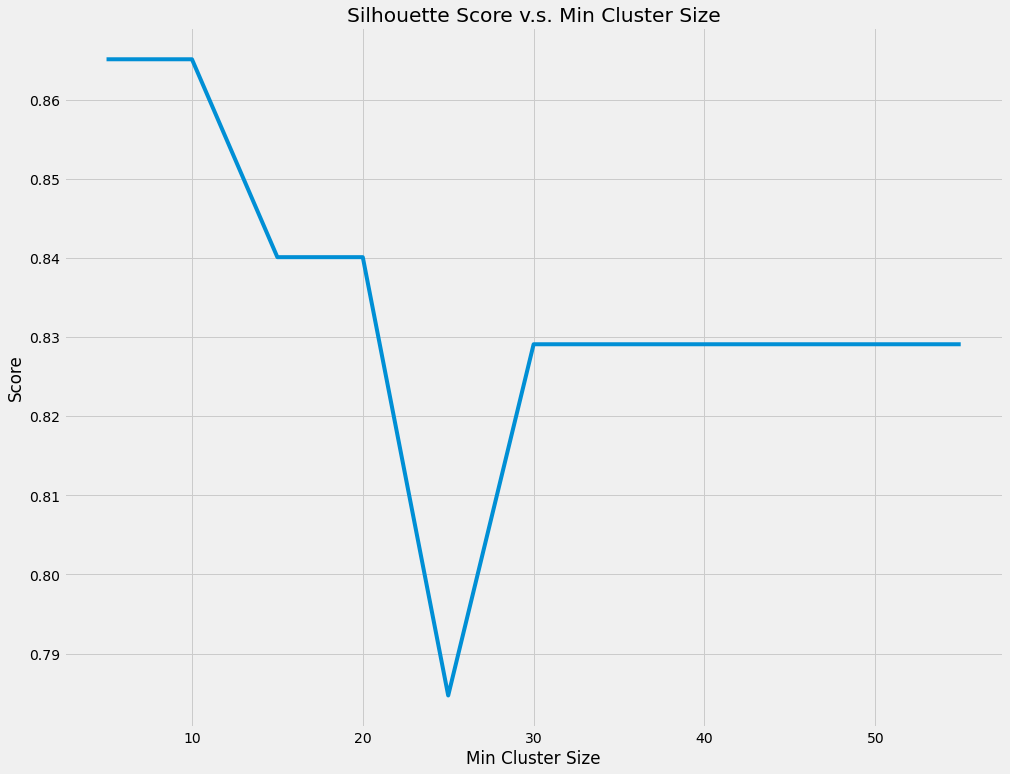

In [21]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(min_cluster_size_range, sc_list_min_cluster_size)
plt.title('Silhouette Score v.s. Min Cluster Size')
plt.xlabel('Min Cluster Size')
plt.ylabel('Score')
plt.show();

In [28]:
kneedle_min_cluster_size = KneeLocator(x=min_cluster_size_range, y=sc_list_min_cluster_size, curve='convex', direction='decreasing', interp_method='polynomial')

print('The heuristically determined optimal min_cluster_size is', kneedle_min_cluster_size.knee)

The heuristically determined optimal min_cluster_size is 25


With `min_cluster_size` fixed, we can now fine-tune the `min_samples` hyper-parameter, which determines the number of training examples in a neighborhood for a point to be considered as a core point.

In [29]:
min_samples_range = range(1, 25, 2)
sc_list_min_samples = []

for min_samples in tqdm(min_samples_range):
    hdbscan_model = HDBSCAN(
        min_cluster_size=kneedle_min_cluster_size.knee,
        min_samples=min_samples,
        metric='euclidean'
    )
    hdbscan_model.fit(cupy_embed_2d)
    # Add score
    sc_list_min_samples.append(cython_silhouette_score(X=cupy_embed_2d, labels=hdbscan_model.labels_))

  8%|▊         | 1/12 [00:00<00:05,  1.84it/s]

Label prop iterations: 3
Iterations: 1
3720,56,104,8,64,852
Label prop iterations: 10
Label prop iterations: 2
Iterations: 2
3673,72,147,10,110,1069
Label prop iterations: 9
Label prop iterations: 8
Label prop iterations: 6
Label prop iterations: 5
Label prop iterations: 3
Iterations: 5
3610,131,266,18,245,1669
Label prop iterations: 6
Label prop iterations: 3
Iterations: 2
3474,68,127,11,103,1020
Label prop iterations: 5
Label prop iterations: 2
Iterations: 2
3459,76,125,9,107,1002
Label prop iterations: 2
Iterations: 1
3488,47,85,6,54,836


 17%|█▋        | 2/12 [00:01<00:05,  1.94it/s]

Label prop iterations: 16
Label prop iterations: 8
Label prop iterations: 6
Label prop iterations: 4
Label prop iterations: 2
Iterations: 5
3416,140,268,21,233,1651
Label prop iterations: 8
Label prop iterations: 5
Label prop iterations: 4
Label prop iterations: 2
Iterations: 4
3224,109,193,16,197,1265
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3207,69,114,10,104,891
Label prop iterations: 2
Iterations: 1
3223,47,77,6,55,763


 25%|██▌       | 3/12 [00:01<00:04,  1.97it/s]

Label prop iterations: 17
Label prop iterations: 10
Label prop iterations: 10
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 6
3360,170,310,23,286,1943
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3231,65,112,10,106,890
Label prop iterations: 2
Iterations: 1
3360,46,78,6,60,746
Label prop iterations: 20


 33%|███▎      | 4/12 [00:02<00:04,  1.99it/s]

Label prop iterations: 7
Label prop iterations: 7
Label prop iterations: 4
Label prop iterations: 3
Iterations: 5
3610,138,273,21,254,1726
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3195,73,122,10,101,873
Label prop iterations: 2
Iterations: 1
3191,47,78,7,53,739


 42%|████▏     | 5/12 [00:02<00:03,  1.96it/s]

Label prop iterations: 17
Label prop iterations: 11
Label prop iterations: 7
Label prop iterations: 4
Label prop iterations: 2
Label prop iterations: 2
Iterations: 6
3379,159,319,23,314,1844
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3239,66,114,10,102,866
Label prop iterations: 2
Iterations: 1
3212,47,77,8,58,742


 50%|█████     | 6/12 [00:03<00:03,  1.87it/s]

Label prop iterations: 21
Label prop iterations: 7
Label prop iterations: 6
Label prop iterations: 3
Label prop iterations: 2
Iterations: 5
3929,141,283,19,257,1633
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3165,67,114,10,103,885
Label prop iterations: 2
Iterations: 1
3522,70,85,11,97,655


 58%|█████▊    | 7/12 [00:03<00:02,  1.77it/s]

Label prop iterations: 19
Label prop iterations: 9
Label prop iterations: 6
Label prop iterations: 4
Iterations: 4
3981,127,253,21,202,1580
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3287,86,119,14,124,797
Label prop iterations: 2
Iterations: 1
3246,56,78,7,58,725


 67%|██████▋   | 8/12 [00:04<00:02,  1.81it/s]

Label prop iterations: 22
Label prop iterations: 8
Label prop iterations: 5
Label prop iterations: 3
Label prop iterations: 2
Iterations: 5
3898,151,292,20,246,1597
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3215,68,113,9,104,866
Label prop iterations: 2
Iterations: 1
3259,56,78,8,62,733
Label prop iterations: 21


 75%|███████▌  | 9/12 [00:04<00:01,  1.83it/s]

Label prop iterations: 7
Label prop iterations: 5
Label prop iterations: 3
Iterations: 4
3931,123,265,18,206,1395
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3245,70,117,13,111,865
Label prop iterations: 2
Iterations: 1
3253,47,81,10,60,731


 83%|████████▎ | 10/12 [00:05<00:01,  1.83it/s]

Label prop iterations: 27
Label prop iterations: 6
Label prop iterations: 4
Label prop iterations: 3
Label prop iterations: 2
Iterations: 5
4227,162,299,20,247,1251
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3184,69,115,10,100,878
Label prop iterations: 2
Iterations: 1
3212,49,79,7,57,732
Label prop iterations: 24


 92%|█████████▏| 11/12 [00:05<00:00,  1.83it/s]

Label prop iterations: 5
Label prop iterations: 4
Label prop iterations: 3
Label prop iterations: 2
Iterations: 5
4024,141,312,20,256,1406
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3187,68,114,10,104,859
Label prop iterations: 2
Iterations: 1
3180,48,79,7,58,751


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]

Label prop iterations: 27
Label prop iterations: 6
Label prop iterations: 3
Label prop iterations: 3
Iterations: 4
5111,136,279,17,197,1065
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3219,70,115,10,102,875
Label prop iterations: 2
Iterations: 1
3232,49,78,7,71,736


Visualize the scores:

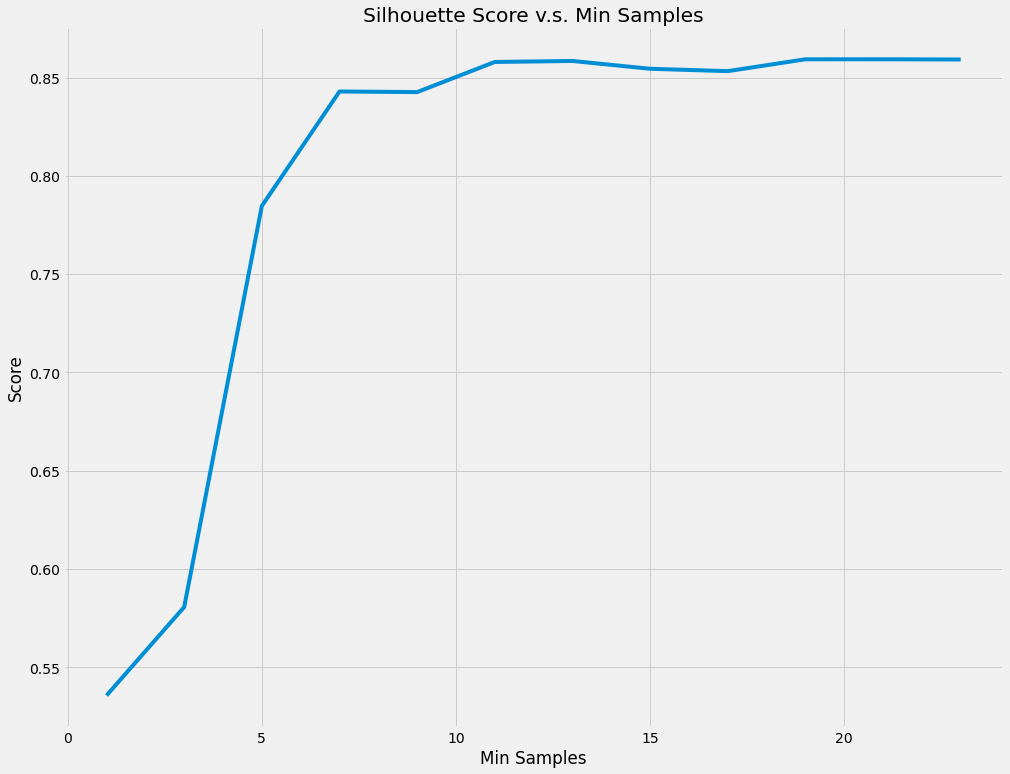

In [30]:
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(min_samples_range, sc_list_min_samples)
plt.title('Silhouette Score v.s. Min Samples')
plt.xlabel('Min Samples')
plt.ylabel('Score')
plt.show();

In [31]:
kneedle_min_samples = KneeLocator(x=min_samples_range, y=sc_list_min_samples, curve='concave', direction='increasing', interp_method='polynomial')

print('The heuristically determined optimal min_samples is', kneedle_min_samples.knee)

The heuristically determined optimal min_samples is 7


Finally, we fit the model with the selected hyper-parameters:

In [32]:
hdbscan_model = HDBSCAN(
    min_cluster_size=kneedle_min_cluster_size.knee,
    min_samples=kneedle_min_samples.knee,
    metric='euclidean'
)
hdbscan_model.fit(cupy_embed_2d)

# Add cluster labels to dataframe
train_text_df['hdbscan_clusters'] = hdbscan_model.labels_

train_text_df.head(5)

Label prop iterations: 20
Label prop iterations: 7
Label prop iterations: 7
Label prop iterations: 4
Label prop iterations: 3
Iterations: 5
3545,150,606,21,250,1764
Label prop iterations: 4
Label prop iterations: 2
Iterations: 2
3301,68,115,16,108,907
Label prop iterations: 2
Iterations: 1
3263,46,78,6,55,744


,id,text,k_means_clusters,hdbscan_clusters
0,62C57C524CD2,I think we should be able to play in a sport i...,7,13
1,80667AD3FFD8,Some schools require summer projects for stude...,2,1
2,21868C40B94F,Driverless cars have been argued and talked ab...,3,4
3,87A6EF3113C6,"The author of ""The Challenge of Exploring Venu...",10,12
4,24687D08CFDA,"Wow, from the mar really look like humans face...",4,10


Visualize the output of HDBSCAN on two-dimensional UMAP embeddings:

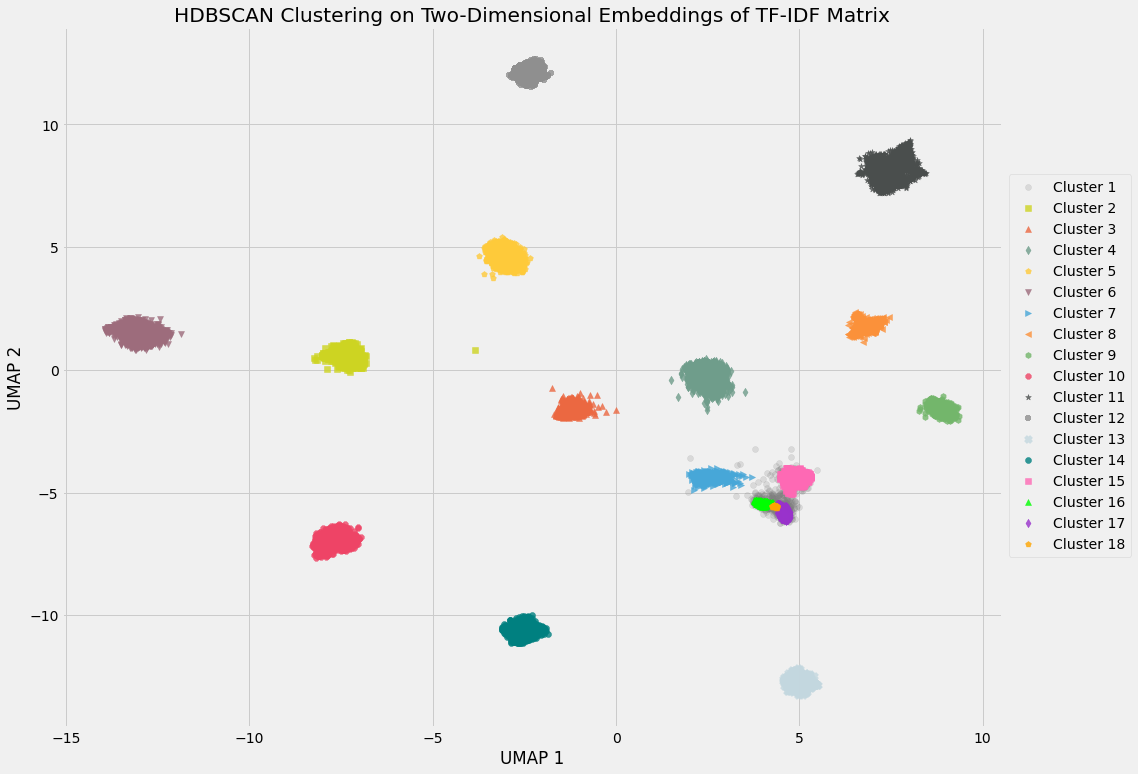

In [44]:
c_hdbscan = cupy.asnumpy(hdbscan_model.labels_)

# Define a color map and markers for each cluster
colors = ['grey', '#cdd422', '#eb6841', '#6f9d8b', '#ffca3a', '#9d6c7c', '#47a7d8', '#fc913a', '#73b66b', '#ee4466', '#4a4e4d', '#8f8f8f', '#c3d7df', '#008080', '#FF69B4', '#00FF00', '#9932CC', '#FFA500']
markers = ['o', 's', '^', 'd', 'p', 'v', '>', '<', 'h', '8', '*', '+', 'x', 'o', 's', '^', 'd', 'p']
alpha = [0.2] + [0.8] * (len(colors) - 1)

# Create the scatter plot
fig, ax = plt.subplots(figsize=fig_size)
for index, c in np.ndenumerate(np.unique(c_hdbscan)):
    mask = c_hdbscan == c
    ax.scatter(x[mask], y[mask], c=colors[index[0]], marker=markers[index[0]], alpha=alpha[index[0]])
    
# Add axis labels and show the plot
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('HDBSCAN Clustering on Two-Dimensional Embeddings of TF-IDF Matrix')
plt.legend(['Cluster ' + str(i) for i in range(1, len(colors) + 1)], bbox_to_anchor=(1, 0.8))
plt.show();

As can be seen, the benefit of using a density-based clustering algorithm is that we can label some train examples (terms) as outliers. Those are the light grey colored points in the plot above. KMeans, on the other hand, would have lumped all data points in clusters 15, 16, 17, and 18 together.

## Display Essay Topics

To add more interpretability to the clustering output, which can be thought of as essay topics, we will plot the most important word corresponding to the centroid of each cluster.

In [63]:
cupy.argmax(cupy.mean(text_embeddings[train_text_df.k_means_clusters.values == 9], axis=0))

array(16880, dtype=int64)

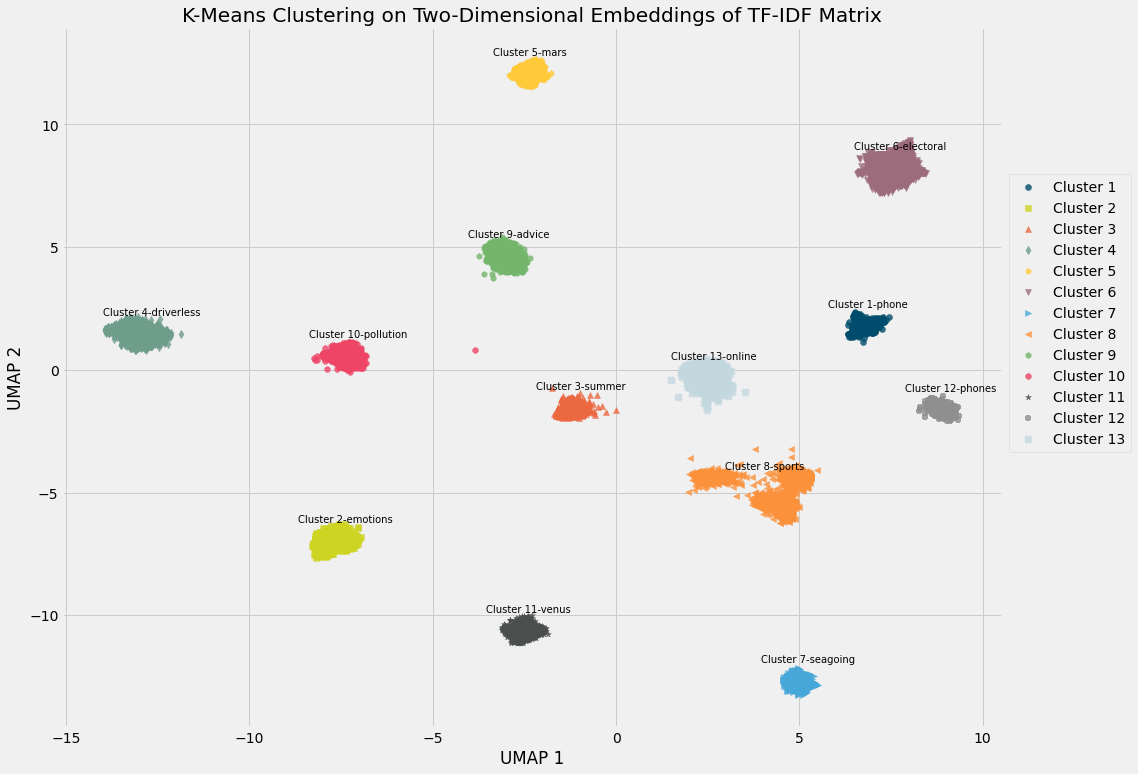

In [69]:
k_means_centroids = k_means_model.cluster_centers_

# Define a color map and markers for each cluster
colors = ['#004c6d', '#cdd422', '#eb6841', '#6f9d8b', '#ffca3a', '#9d6c7c', '#47a7d8', '#fc913a', '#73b66b', '#ee4466', '#4a4e4d', '#8f8f8f', '#c3d7df']
markers = ['o', 's', '^', 'd', 'p', 'v', '>', '<', 'h', '8', '*', '+', 'x']
alpha = [0.8] * len(colors)

# Create the scatter plot
fig, ax = plt.subplots(figsize=fig_size)
for index, c in np.ndenumerate(np.unique(c_kmeans)):
    mask = c_kmeans == c
    ax.scatter(x[mask], y[mask], c=colors[index[0]], marker=markers[index[0]], alpha=alpha[index[0]])

# Add cluster most important token (word)
for k in range(len(k_means_centroids)):
    # Compute the mean values for each of the 25,000 terms among all documents for each cluster
    terms_mean_tfidf_for_cluster_k = cupy.mean(text_embeddings[train_text_df.k_means_clusters.values == k], axis=0) 
    highest_tfidf_for_cluster_k_index = cupy.argmax(terms_mean_tfidf_for_cluster_k)
    # Maps from feature integer index to feature name (token)
    top_word = tfidf.vocabulary_.iloc[highest_tfidf_for_cluster_k_index]
    # Add annotation text to plot
    plt.text(k_means_centroids[k, 0] - 1, k_means_centroids[k, 1] + 0.75, f'Cluster {k + 1}-{top_word}', size=10)

# Add axis labels and show the plot
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('K-Means Clustering on Two-Dimensional Embeddings of TF-IDF Matrix')
plt.legend(['Cluster ' + str(i) for i in range(1, len(colors) + 1)], bbox_to_anchor=(1, 0.8))
plt.show();

## Display Example Text

In [80]:
for k in range(3):
    
    terms_mean_tfidf_for_cluster_k = cupy.mean(text_embeddings[train_text_df.k_means_clusters.values == k], axis=0) 
    # Slice the array starting from the fifth element [-5:] from the end, i.e., top five tf-idf before reversing the array with [::-1]
    top_five_words_indices = cupy.asnumpy(cupy.argsort(terms_mean_tfidf_for_cluster_k)[-5:][::-1]) 
    top_words = tfidf.vocabulary_.to_array()[top_five_words_indices]
    
    print('#' * 60)
    print(f'# Essay Topic {k + 1}')
    print('# Top 5 Words', top_words)
    print('#'* 60)
    print('\n\n\n')
    
    # For each topic, find three example essays
    temp_df = train_text_df.loc[train_text_df.k_means_clusters.values == k].sample(3, random_state=seed)
    
    for j in range(3):
        txt = temp_df.iloc[j, 1]
        print('-' * 10, f'Example {j + 1}','-'*10, '\n')
        print(txt, '\n\n\n')

############################################################
# Essay Topic 1
# Top 5 Words ['phone' 'phones' 'driving' 'texting' 'road']
############################################################




---------- Example 1 ---------- 

Phones and driving

The National Safety Council reports that cell phone use while driving leads to 1.6 million crashes each year. That's out of control. America has an addiction problem, and it's all about cell phones. You see ads on tv, on your phone, on billboards, pretty much everywhere, and they are taking american lives.

There's a lot of problems phones bring to the table, but Americans getting distracted by them is one of the most common causes of death in the us. One quick peek at your phone and suddenly there's a semi truck coming at you 100 miles per hour. It can happen in almost an instant. And the numbers are there to back it up! There is no way more than 25% of the people killed per year expected or saw the crash coming.

The government has 